## EA For CIFAR100

Object: generate the code of architecture and acc pairs to train the accuracy predictor

1. encode the model
2. get acc
3. match the code and acc to pair

### Encode the model

In [3]:
import sys
sys.path.append("/home/qhy/Reserach/AICAS/encode+decode")
from encode import encode
import numpy as np
import os
import tqdm
import torch
from easydict import EasyDict
import yaml
def encode(num,config):
    mapping_op = {'repvgg':0,'vgg':1}
    mapping_pool = {'maxpool':0,'avgpool':1,"None":2}
    code = []
    if config['model']["stage_ratio"] != None:
        code += config['model']["stage_ratio"]
    else:
        print("Error in stage ration")
    
    if config['model']['op_type'] != None:
        code += [mapping_op[i] for i in config['model']['op_type']]
    else:
        print("Error in op type")
    
    
    mapping_pool = {"maxpool":0,"avgpool":1,None:2}
    if config['model']['pool_type'] != None:
        code += [mapping_pool[i] for i in config['model']['pool_type']]
    else:
        print("Error in maxpool")
    if config['model']['stage_layer'] != None:
        code += config['model']['stage_layer']
    else:
        print("Error in stage layer")
    assert len(code) == 21,print(num,len(code),code)
    return code


In [17]:
model_list = os.listdir("/home/qhy/Reserach/AICAS/config/cifar100")
data = {}
acc_list = np.zeros(392)
for model_path in tqdm.tqdm(model_list):
    # print(model_path)
    config_path = os.path.join("/home/qhy/Reserach/AICAS//config/cifar100/",model_path)
    model_path_2 = os.path.join("/home/qhy/Reserach/AICAS//log/cifar100/",model_path.replace(".yaml",""),"best_ckpt.pth")
    
    if "benchmark" not in model_path:
        num = int(model_path.split("-")[0])
        # print(num)
        if os.path.exists(model_path_2) :
            param = torch.load(model_path_2)
            acc = param['max_accuracy']
            acc_list[num] = acc
            if(acc>0.1):
                config = EasyDict(yaml.full_load(open(config_path)))
                code = encode(config=config,num=num)
                data[num] = {"code":code,"acc":acc}
                # print(num,"done")
# code_dataset = []
# acc_dataset = []
# for k in data.keys():
#     code_dataset.append(data[k]['code'])
#     acc_dataset.append(data[k]['acc'])
np.save("/home/qhy/Reserach/AICAS/predictor/dataset/cifar100-data-dict-0-391.npy",data)
# np.save("/home/qhy/Reserach/AICAS/predictor/dataset/acc-dict-980.npy",np.array(acc_dataset))   

100%|██████████| 387/387 [09:33<00:00,  1.48s/it]


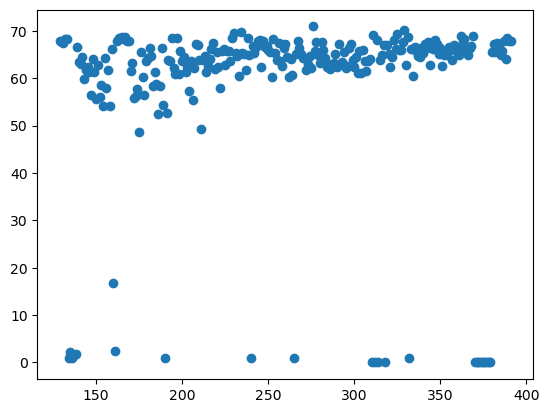

In [19]:
import matplotlib.pyplot as plt
plt.scatter(range(129,392),acc_list[129:392])

In [20]:
new_data = {}
for k in data.keys():
    if k > 129 and data[k]['acc'] > 20:
        new_data[k] = data[k]

np.save("/home/qhy/Reserach/AICAS/predictor/dataset/cifar100-data-dict-129-392-acc_above-20.npy",new_data)
        

## Predictor

In [ ]:
def add_new_pair(data_path,config_path,key,model_path,save_path):
    new_data = np.load(data_path,allow_pickle=True).item()
    config = EasyDict(yaml.full_load(open(config_path)))
    num = key
    param = torch.load(model_path)
    acc = param['max_accuracy']
    code = encode(config=config,num=num)
    new_data[num] = {"code":code,"acc":acc}
    np.save(save_path,new_data)
data_path = "/home/qhy/Reserach/AICAS/predictor/dataset/cifar100-data-dict-129-392-acc_above-20.npy"
data = np.load(data_path,allow_pickle=True).item()
for p in os.listdir("/home/qhy/Reserach/AICAS/log/search-best-cifar100"):
    num = int(p.split('-')[0])
    if num>0:
        config_path = "/home/qhy/Reserach/AICAS/config/search-best-cifar100/"+p+'.yaml'
        model_path = "/home/qhy/Reserach/AICAS/log/search-best-cifar100/" + p +'/best_ckpt.pth'
        config = EasyDict(yaml.full_load(open(config_path)))
        param = torch.load(model_path)
        acc = param['max_accuracy']
        code = encode(config=config,num=num)
        data[num] = {"code":code,"acc":acc}
        print(acc)
save_path = "/home/qhy/Reserach/AICAS/predictor/dataset/cifar100-data-dict-129-392-acc_above-20-add_best-searchx5.npy"
np.save(save_path,data)

In [48]:
acc_list_all = []
code_list_all = []
data_path = "/home/qhy/Reserach/AICAS/predictor/dataset/cifar100-data-dict-129-392-acc_above-20-add_best-searchx5.npy"
dataset = np.load(data_path,allow_pickle=True).item()
for k in dataset.keys():
    acc_list_all.append(dataset[k]['acc'])
    code_list_all.append(dataset[k]['code'])
train_num = 140
train_acc_dataset = acc_list_all[:train_num]
train_code_dataset = code_list_all[:train_num]
test_acc_dataset = acc_list_all[train_num:]
test_code_dataset = code_list_all[train_num:]
# train_acc_dataset = acc_list_all[train_num-50:train_num]
# train_code_dataset = code_list_all[train_num-50:train_num]
# test_acc_dataset = acc_list_all[train_num:train_num+50]
# test_code_dataset = code_list_all[train_num:train_num+50]
print(len(acc_list_all))
print(max(train_acc_dataset ))
print(max(test_acc_dataset))

244
70.1
70.9


In [53]:
from sklearn import metrics
import sys
import torch
sys.path.append("..")
from predictor.mlp import fit
hyperparams = {
    "input_dims" : 21,
    "num_layers" : 5,
    "layer_width" : [ 40, 80, 40, 20, 10],
    "batch_size" : 100,
    "lr" : 0.01,
    "regularization":0.1,
    "ratio": 0.00001,
    "loss": "mse" #"pair_loss" # "pair_loss" #'mae' "mse"
    
}
R2_test_max = -1
R2_train_max = -1

R2_SUM = -1

for num in range(10):
    train_error,model_trained = fit(hyperparams,train_code_dataset,train_acc_dataset,epochs=500,verbose=0)
    test_pred = []
    for i in test_code_dataset:
        input = torch.tensor(i).to(torch.float32)
        test_pred.append(model_trained(input).detach().numpy())
    test_acc_dataset = np.array(test_acc_dataset)
    test_pred = np.array(test_pred)
    MSE = metrics.mean_squared_error(test_acc_dataset, test_pred)
    R2_test = 1 - (MSE/np.mean((test_pred-np.mean(test_acc_dataset))**2))
    train_pred = []
    for i in train_code_dataset:
        input = torch.tensor(i)
        train_pred.append(model_trained(input).detach().numpy())
    train_acc_dataset = np.array(train_acc_dataset)
    train_pred = np.array(train_pred)
    MSE = metrics.mean_squared_error(train_acc_dataset, train_pred)
    R2_train = 1 - (MSE/np.mean((train_pred-np.mean(train_acc_dataset))**2))
    
    if R2_test_max<R2_test:
        R2_test_max = R2_test
        better_model_test = model_trained
        print(num,train_error,R2_test_max)
    if R2_train_max<R2_train:
        R2_train_max = R2_train
        better_model_train = model_trained
        print(num,train_error,R2_train_max)
    if R2_SUM <(R2_test+R2_train) :
        better_model_sum = model_trained
        R2_SUM  = R2_test+R2_train
        print(num,train_error,R2_SUM)

100%|██████████| 500/500 [00:02<00:00, 208.30it/s]


0 1.4301828962053578 0.5779583572281537
0 1.4301828962053578 0.8178956516205739
0 1.4301828962053578 1.3958540088487275


100%|██████████| 500/500 [00:02<00:00, 226.15it/s]


2 1.2918533739362439 0.8543613763973625


100%|██████████| 500/500 [00:02<00:00, 209.40it/s]


3 0.7335617697579522 0.6179156395589986
3 0.7335617697579522 0.9286583578485819
3 0.7335617697579522 1.5465739974075805


100%|██████████| 500/500 [00:02<00:00, 190.46it/s]


5 0.5223986075265068 0.9633722033831581
5 0.5223986075265068 1.5639167491425012


100%|██████████| 500/500 [00:02<00:00, 222.43it/s]


7 0.8781351590837753 0.6991935338298303
7 0.8781351590837753 1.5856487411658113


100%|██████████| 500/500 [00:02<00:00, 206.41it/s]


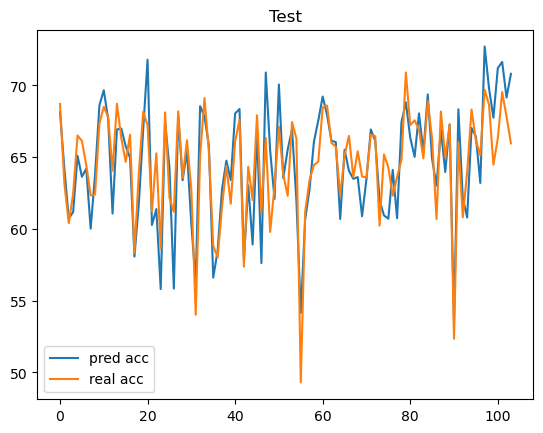

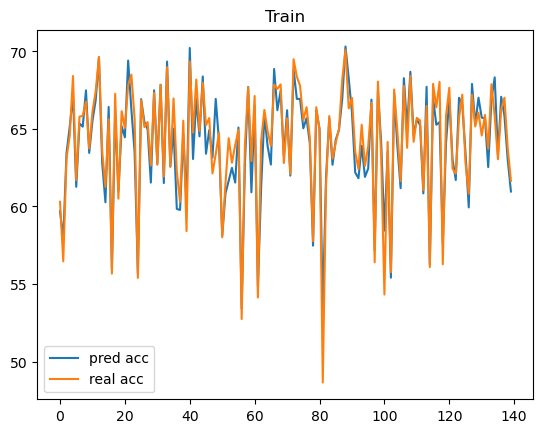

====TRAIN====
std 5.109953539818136
mean -0.21272187042236385
MSE 1.3909016200447166
RMSE 1.1793649223394413
MAE 0.878135322570801
MAPE 0.013875083071181347
R2 0.886455207335981
spearmanr R 0.9327424489030853
spearmanr P 5.26171322440781e-63
====TEST====
std 5.494903441808962
mean 0.2911595452696407
MSE 4.899213883397404
RMSE 2.2134167893547305
MAE 1.750970571958102
MAPE 0.027461055493778752
R2 0.6991935338298303
spearmanr R 0.8270144420763323
spearmanr P 2.9140466983097383e-27
diff2 = 1762.423076923077


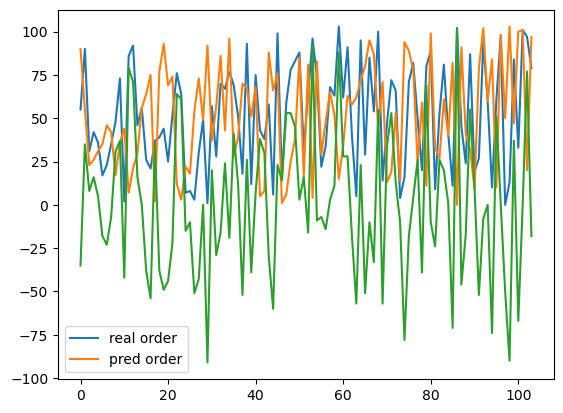

In [54]:
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import stats
model_trained = better_model_sum
test_pred = []
for i in test_code_dataset:
    input = torch.tensor(i)
    test_pred.append(model_trained(input).detach().numpy())
plt.plot(range(len(test_pred)),test_pred,label="pred acc")
plt.plot(range(len(test_pred)),test_acc_dataset,label="real acc")
plt.legend()
plt.title("Test")
plt.show()

train_pred = []
for i in train_code_dataset:
    input = torch.tensor(i)
    train_pred.append(model_trained(input).detach().numpy())
plt.plot(range(len(train_pred)),train_pred,label="pred acc")
plt.plot(range(len(train_pred)),train_acc_dataset,label="real acc")
plt.legend()
plt.title("Train")
plt.show()
print("====TRAIN====")
train_acc_dataset = np.array(train_acc_dataset)
train_pred = np.array(train_pred)
MSE = metrics.mean_squared_error(train_acc_dataset, train_pred)
RMSE = metrics.mean_squared_error(train_acc_dataset, train_pred)**0.5
MAE = metrics.mean_absolute_error(train_acc_dataset, train_pred)
MAPE = metrics.mean_absolute_percentage_error(train_acc_dataset, train_pred)
r_train,p_train = stats.spearmanr(train_acc_dataset, train_pred)
R2_train = 1 - (MSE/np.mean((train_pred-np.mean(train_acc_dataset))**2))
print("std",np.std(np.array(train_pred)-train_acc_dataset))
print("mean",np.mean(np.array(train_pred)-train_acc_dataset))
print("MSE", MSE)
print("RMSE", RMSE)
print("MAE",MAE)
print("MAPE",MAPE)
print("R2",R2_train)
print("spearmanr R",r_train)
print("spearmanr P",p_train)

print("====TEST====")
test_acc_dataset = np.array(test_acc_dataset)
test_pred = np.array(test_pred)
MSE = metrics.mean_squared_error(test_acc_dataset, test_pred)
RMSE = metrics.mean_squared_error(test_acc_dataset, test_pred)**0.5
MAE = metrics.mean_absolute_error(test_acc_dataset, test_pred)
MAPE = metrics.mean_absolute_percentage_error(test_acc_dataset, test_pred)
R2_test = 1 - (MSE/np.mean((test_pred-np.mean(test_acc_dataset))**2))
r_test,p_test = stats.spearmanr(test_acc_dataset, test_pred)

print("std",np.std(np.array(test_pred)-np.array(train_acc_dataset)))
print("mean",np.mean(np.array(test_pred)-np.array(train_acc_dataset)))
print("MSE", MSE)
print("RMSE", RMSE)
print("MAE",MAE)
print("MAPE",MAPE)
print("R2",R2_test)
print("spearmanr R",r_test)
print("spearmanr P",p_test)

real_order = test_acc_dataset.argsort()
pred_order = test_pred.squeeze().argsort()
plt.plot(range(pred_order.shape[0]),real_order,label="real order")
plt.plot(range(pred_order.shape[0]),pred_order,label="pred order")
plt.legend()
plt.plot(range(pred_order.shape[0]),real_order-pred_order,label="diff")
diff2 = ((real_order-pred_order)**2).sum()/pred_order.shape[0]
print("diff2 =",diff2)



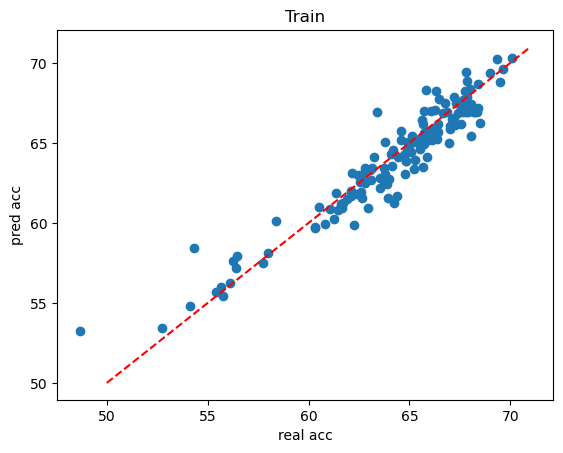

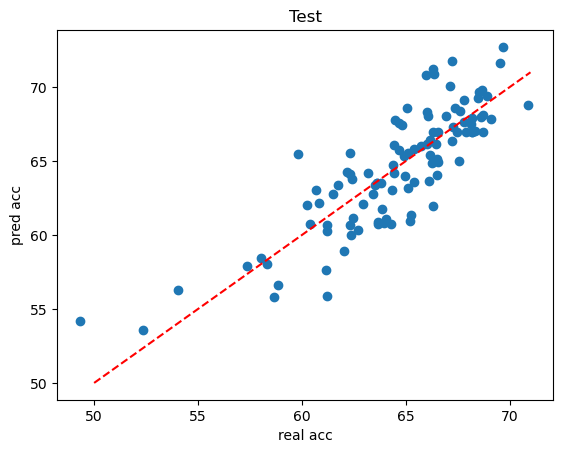

In [55]:
plt.scatter(train_acc_dataset,train_pred)
plt.plot(range(50,72),range(50,72),'--',c="r")
plt.title("Train")
plt.xlabel("real acc")
plt.ylabel("pred acc")
plt.show()
plt.scatter(test_acc_dataset,test_pred)
plt.plot(range(50,72),range(50,72),'--',c="r")
plt.title("Test")
plt.xlabel("real acc")
plt.ylabel("pred acc")
plt.show()

In [56]:
import os
save_model = {
    "hyperparams":hyperparams,
    "model":model_trained.state_dict(),
    "R2-train": R2_train,
    "R2-test": R2_test,
    "R-train":r_train,
    "R-test":r_test
}
save_path = "/home/qhy/Reserach/AICAS/predictor/MLP/cifar100/"+"loss-"+hyperparams['loss']+"-ratio-"+str(hyperparams['ratio'])+"-input_dims-"+str(hyperparams["input_dims"])+"-train_num-"+str(train_num)+'-num_layers-'+str(hyperparams["num_layers"])+'-layer_width-'+'_'.join([str(i) for i in hyperparams["layer_width"]]) + '-lr-'+str(hyperparams['lr'])+'-regular-'+str(hyperparams['regularization'])+"-r-train-"+str(round(r_train,4))+"-r-test-"+str(round(r_test,4))+"-diff2-"+str(round(diff2,4))+'.pth'
if os.path.exists(save_path):
    save_path = save_path.replace(".pth","-1.pth")
torch.save(save_model,save_path)
save_path

'/home/qhy/Reserach/AICAS/predictor/MLP/cifar100/loss-mse-ratio-1e-05-input_dims-21-train_num-140-num_layers-5-layer_width-40_80_40_20_10-lr-0.01-regular-0.1-r-train-0.9327-r-test-0.827-diff2-1762.4231.pth'

## Evolurationary Algorithm

In [2]:
from latency import *

In [4]:
import numpy as np
import geatpy as ea
import torch 
import sys
sys.path.append("..")
from predictor.mlp import FeedforwardNet
sys.path.append("/home/qhy/Reserach/AICAS/encode+decode")
from decode import decode,decode_lite
model_paths = ["/home/qhy/Reserach/AICAS/predictor/MLP/cifar100/loss-mse-ratio-1e-05-input_dims-21-train_num-150-num_layers-6-layer_width-40_80_60_40_20_10-lr-0.1-regular-0.1-r-train-0.8732-r-test-0.8913-diff2-1421.9091.pth",
               "/home/qhy/Reserach/AICAS/predictor/MLP/cifar100/loss-mse-ratio-1e-05-input_dims-21-train_num-180-num_layers-5-layer_width-40_80_40_20_10-lr-0.1-regular-0.1-r-train-0.932-r-test-0.8354-diff2-655.6875.pth",
               "/home/qhy/Reserach/AICAS/predictor/MLP/cifar100/loss-mse-ratio-1e-05-input_dims-21-train_num-180-num_layers-6-layer_width-40_80_60_40_20_10-lr-0.1-regular-0.1-r-train-0.884-r-test-0.8471-diff2-595.8438.pth",
               "/home/qhy/Reserach/AICAS/predictor/MLP/cifar100/loss-pair+mse-ratio-1e-05-input_dims-21-train_num-180-num_layers-5-layer_width-40_80_40_20_10-lr-0.1-regular-0.1-r-train-0.9598-r-test-0.8681-diff2-527.5625.pth",
               ]
model_path = model_paths[3] #21
model_param = torch.load(model_path)
hyperparams = model_param["hyperparams"]
predictor = FeedforwardNet(hyperparams["input_dims"],hyperparams["num_layers"],hyperparams["layer_width"],1,'relu')
predictor.load_state_dict(model_param['model'])


<All keys matched successfully>

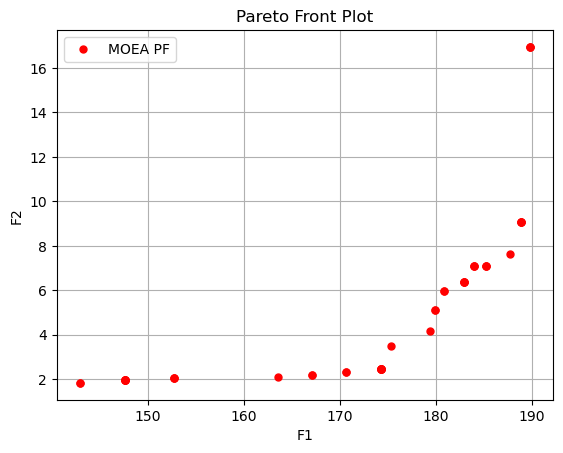

Execution time: 2743.720010280609 s
Evaluation number: 2500
The number of non-dominated solutions is: 47
hv: 0.28504
spacing: 0.72787


In [10]:
class EA_M(ea.Problem):  # 继承Problem父类
    def __init__(self,model):
        name = 'EA'  # 初始化name（函数名称，可以随意设置）
        M = 2  # 优化目标个数
        maxormins = [-1, 1]   # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = M  # 初始化Dim（决策变量维数）
        varTypes = [1] * 31  # 初始化varTypes（决策变量的类型，0：实数；1：整数）
        lb = [4]*5+[0]*5+[0]*6+[2,2,2,2,2]+[1]*5+[3]+[1]*4  # 决策变量下界
        ub = [8]*5+[1]*5+[2]*6+[2,4,6,8,4]+[5]*5+[3]+[5]*4  # 决策变量上界
        lbin = [1]*31  # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1]*31  # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        self.predictor = model
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)

    def aimFunc(self, pop):  # 目标函数
        Vars = pop.Phen  # 获取决策变量矩阵，它等于种群的表现型矩阵Phen
        Vars = torch.tensor(np.array(Vars,dtype=np.float32))
        np_Vars = np.array(Vars,dtype=np.float32)
        accuracy = []
        latency = []
        BRAM = []
        DSP = []
        r_shift = [9]*30
        classify = 10
        for i in range(Vars.shape[0]):
            acc = self.predictor(Vars[i][:21]*1.0).detach().numpy()
            accuracy.append(acc) 
            code = np_Vars[i][:21]/np.array([8]*5+[1]*16)
            channels = [64,64,128,256,512]
            layers = np_Vars[i][16:21].astype(int)
            out_channels = []
            for out_ch in range(5):
                out_channels += [(code[out_ch]*channels[out_ch]).astype(int)]*layers[out_ch]
            in_channels = [3]+out_channels[:-1]
            pe = []
            out_ch = 0
            for p in range(5):
                for layer_num in range(int(np_Vars[i][16+p])):
                    while out_channels[out_ch] % (2**int(np_Vars[i][21+p])) != 0:
                        np_Vars[i][21+p] -= 1
                    pe += [2**int(np_Vars[i][21+p])]
                    out_ch += 1
                Vars[i][21+p].data = torch.tensor(np_Vars[i][21+p])
            if int(np_Vars[i][16])==2:
                simd = [int(np_Vars[i][26])]+[int(np_Vars[i][0]/8*64*0.5)]
                in_ch = 2
            else:
                simd = [int(np_Vars[i][26])]
                in_ch = 1

            for si in range(4):
                for layer_num in range(int(np_Vars[i][17+si])):
                    while in_channels[in_ch] % (2**int(np_Vars[i][27+si])) != 0:
                        np_Vars[i][27+si] -= 1
                    simd += [2**int(np_Vars[i][27+si])]
                    in_ch += 1
                Vars[i][27+si].data = torch.tensor(np_Vars[i][27+si])
            # if int(np_Vars[i][16])==2:
            #     simd = [int(np_Vars[i][26])]+[int(np_Vars[i][0]/8*64*0.5)]
            # else:
            #     simd = [int(np_Vars[i][26])]
            # Vars[i][26].data = torch.tensor(np_Vars[i][26])
            # for si in range(4):
            #     while in_channels[1+si] % (2**int(np_Vars[i][27+si])) != 0:
            #         np_Vars[i][27+si] -= 1
            #     simd += [2**int(np_Vars[i][27+si])]*int(np_Vars[i][17+si])
            #     Vars[i][27+si].data = torch.tensor(np_Vars[i][27+si])
                # [2**int(np_Vars[i][27])]*int(np_Vars[i][17])+[2**int(np_Vars[i][28])]*int(np_Vars[i][18])+[2**int(np_Vars[i][29])]*int(np_Vars[i][19])+[2**int(np_Vars[i][30])]*int(np_Vars[i][20])
            
            # print(in_channels,out_channels,code[:5],code[:5]*np.array([64,64,128,256,512]),pe,simd)
            # print(Vars[i])
            config = model_analysis(code, pe, simd, r_shift, classify)
            conv_param, conv_config = config_param(code, config)
            bram, dsp, cycle = hw_inference(code, config)
            latency.append([cycle])
            BRAM.append(bram)
            DSP.append(dsp)
        accuracy = np.array(accuracy)
        latency = np.array(latency)
        # print(accuracy.shape)
        # print(latency.shape)
        pop.ObjV = np.hstack([accuracy,latency])  # 计算目标函数值矩阵，赋值给种群对象的ObjV属性
        pop.CV = np.array([np.array(BRAM)-1824*2,np.array(DSP)-2520*2]).transpose(1,0)  # 构建违反约束程度矩阵，赋值给种群对象的CV属性
        # print(pop.CV.shape,pop.CV.ndim,pop.sizes)
# 实例化问题对象
# problem = EA_M(predictor)
problem = EA_M(predictor)
algorithm = ea.moea_NSGA2_templet(problem,
                                ea.Population(Encoding='RI', NIND=50),
                                MAXGEN=50,  # 最大进化代数。
                                logTras=1,  # 表示每隔多少代记录一次日志信息，0表示不记录。
                                trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
                                maxTrappedCount=10)  # 进化停滞计数器最大上限值。

# 求解
res = ea.optimize(algorithm, seed=1, verbose=False, drawing=1, outputMsg=True, drawLog=False, saveFlag=True, dirName='result')


In [11]:
import sys
sys.path.append("../encode+decode/")
from decode import decode
con_map = {0:"acc+flops+params",1:"acc",2:"acc+flops",3:"acc+params",4:"flops",5:"params",6:"param+flops",7:"acc+latency"}
n = 107
for i in range(50):
    config,save_path = decode(list(res['Vars'][i][:21].astype(int)),"cifar100",n=n,save=False,constrain = con_map[7]) 
    write2yaml(config,save_path) 
    n=n+1
    

-  1.0
-  1.0
-  0.5
-  0.875
-  0.5
-  2
-  2
-  2
-  2
-  2
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
-  1.0
-  0.75
-  0.5
-  0.875
-  0.5
-  2
-  2
-  2
-  2
-  2
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.a

IndexError: index 47 is out of bounds for axis 0 with size 47

In [12]:
np.save("./cifar100-3-3.npy",res['Vars'])

In [13]:
res['Vars'].shape

(47, 31)